In [1]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import os
import pandas as pd

In [2]:
def imshow(image, show_axes = False, quiet = False):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image)
    if not show_axes:
        # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
        plt.axis('off')
    if not quiet:
        # Make sure it outputs
        plt.show()

In [34]:
folder = "../_data"
images = os.listdir(folder)
targetimg  = cv2.cvtColor(cv2.imread(os.path.join(folder,'_img', 'A_plan.tif')),cv2.COLOR_BGR2RGB)
originimg  = cv2.cvtColor(cv2.imread(os.path.join(folder, '_img','A_perspective.jpg')),cv2.COLOR_BGR2RGB)

# 1. Find Homography

In [12]:

reference = pd.read_csv(os.path.join(folder, 'A_perspective.points'))
reference


,mapX,mapY,pixelX,pixelY,enable,dX,dY,residual
0,831348.416148,816242.060411,1035.130435,-1048.695652,1,-36.622105,-115.921198,121.568510
1,831347.780550,816243.490505,1074.260870,-910.956522,1,-46.975610,-79.113591,92.009065
2,831344.549598,816244.126102,886.434783,-766.956522,1,16.076651,-47.257459,49.917192
3,831343.437303,816239.465056,521.739130,-874.956522,1,75.708067,-49.524970,90.467862
4,831332.738085,816258.003305,956.869565,-512.608696,1,-6.524597,0.513537,6.544776
5,831338.034728,816263.035116,1134.521739,-511.043478,1,-37.164959,2.339829,37.238542
6,831318.384184,816244.549833,494.347826,-513.391304,1,64.465164,-1.512039,64.482894
7,831307.843865,816234.592145,283.043478,-516.521739,1,-9.527306,-5.312358,10.908286
8,831312.571119,816239.061187,362.869565,-514.173913,1,38.342927,-2.673945,38.436051
9,831323.323303,816249.131429,623.478261,-511.826087,1,68.280342,0.619694,68.283154


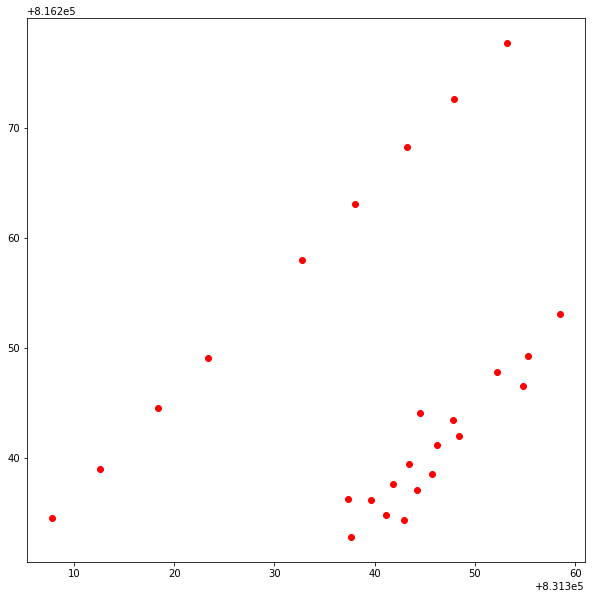

In [15]:
f, ax = plt.subplots(figsize = (10,10))
ax.scatter(reference['mapX'], reference['mapY'], color = 'red')

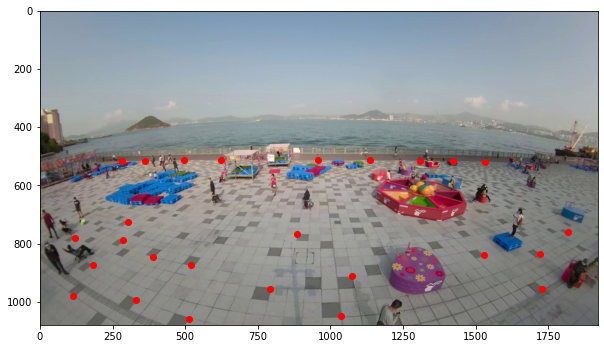

In [17]:
# Origin

fig = plt.subplots(figsize = (10,10))

plt.imshow(originimg)
plt.scatter(reference['pixelX'], -1*reference['pixelY'], color = 'red')


In [31]:
def get_proj_matrix(ref):
    '''
    pts_src and pts_dst are numpy arrays of points

    in source and destination images. We need at least

    corresponding points.

    '''
    pts_src = np.array([(x,y) for x,y in zip(ref['pixelX'], -1*ref['pixelY'])])

    pts_dst  = np.array([(x,y) for x,y in zip(ref['mapX'], ref['mapY'])])

    h, status = cv2.findHomography(pts_src, pts_dst)

    '''
    The calculated homography can be used to warp

    the source image to destination. Size is the

    size (width,height) of im_dst
    '''
    return h, status

def projectPlan(df, h, x, y):
    pts = df[[x, y]].values
    pts1 = pts.reshape(-1,1,2).astype(np.float32)
    dst1 = cv2.perspectiveTransform(pts1, h)
    return dst1

In [32]:
h, status = get_proj_matrix(reference)
print(h)
# print(status)
test = projectPlan(reference, h, 'pixelX', 'pixelY')
# test

[[ 2.23442297e+00 -2.12146786e+03  8.31368814e+05]
 [ 2.19396467e+00 -2.08289652e+03  8.16240799e+05]
 [ 2.70054672e-06 -2.55182714e-03  1.00000000e+00]]


array([[[831353.94, 816235.4 ]],

       [[831353.94, 816235.  ]],

       [[831354.8 , 816235.4 ]],

       [[831355.8 , 816236.75]],

       [[831355.1 , 816234.56]],

       [[831354.3 , 816233.75]],

       [[831357.25, 816236.6 ]],

       [[831358.25, 816237.56]],

       [[831357.9 , 816237.2 ]],

       [[831356.7 , 816236.06]],

       [[831356.4 , 816237.1 ]],

       [[831352.5 , 816233.44]],

       [[831351.8 , 816232.75]],

       [[831351.9 , 816233.1 ]],

       [[831351.44, 816232.1 ]],

       [[831353.5 , 816233.  ]],

       [[831353.  , 816232.5 ]],

       [[831352.5 , 816232.  ]],

       [[831355.44, 816236.8 ]],

       [[831356.1 , 816237.3 ]],

       [[831356.8 , 816238.  ]],

       [[831356.94, 816237.8 ]],

       [[831356.9 , 816237.5 ]],

       [[831357.5 , 816238.06]],

       [[831354.75, 816235.94]],

       [[831357.06, 816237.44]]], dtype=float32)

# Transform Identified Pedestrian location

In [40]:
prediction = pd.read_pickle(os.path.join(folder, 'Waterfront_0318.p'))
prediction  = prediction[prediction['class_id']==1].reset_index(drop=True)
sample = prediction[prediction['FrameID'] == 'frame1304'].reset_index(drop = True) # this is frame 1304
sample['y_img'] = 1080 - sample['y']

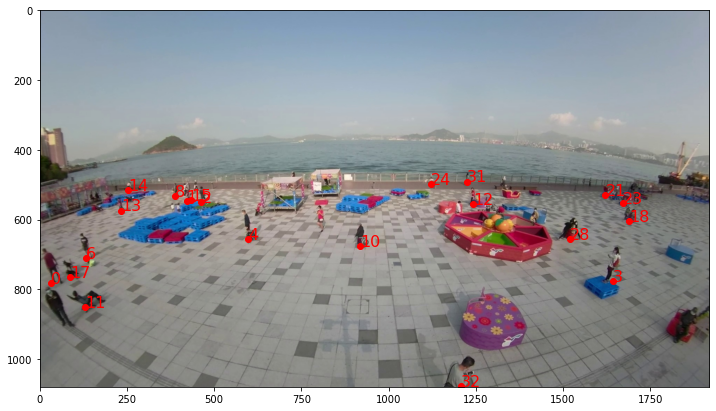

In [42]:
# Show people's location at images
fig = plt.subplots(figsize = (12,12))

plt.imshow(originimg)
plt.scatter(sample['x'], sample['y_img'], color = 'red')
n = sample.label.values
for i, txt in enumerate(n):
    plt.annotate(txt, (sample['x'][i], sample['y_img'][i]), size = 16, color = 'red')
plt.show()

In [43]:
pts = sample[['x','y_img']].values
pts1 = pts.reshape(-1,1,2).astype(np.float32)
dst1 = cv2.perspectiveTransform(pts1, h)

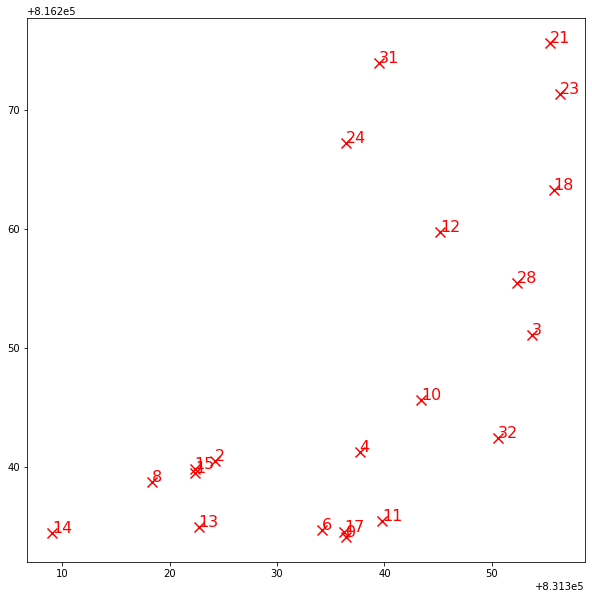

In [45]:
fig = plt.subplots(figsize = (10,10))
plt.scatter(dst1[:,:,0], dst1[:,:,1], marker="x", s=100, c=[(1.0,0,0)])
for i, txt in enumerate(n):
    plt.annotate(txt, (dst1[:,:,0][i], dst1[:,:,1][i]), size = 16, color = 'red')
plt.show()

# 

<AxesSubplot:>

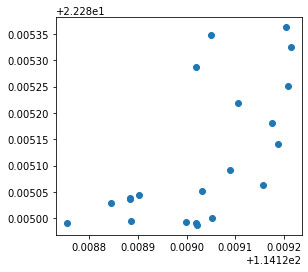

In [46]:
# convert to lat lon
import geopandas as gpd
gdf = gpd.GeoDataFrame(sample, geometry=gpd.points_from_xy(dst1[:,:,0].flatten(), dst1[:,:,1].flatten()), crs = 'EPSG:2326')
gdf = gdf.to_crs('EPSG:4326')
gdf.plot()

In [48]:
# save to geojson for visualization
gdf.to_file(os.path.join(folder, 'sample_prediction.geojson'), driver='GeoJSON')